In [2]:
#imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches

import glob

from IPython.display import Image
from IPython.display import display

from scipy.ndimage import gaussian_filter1d
from scipy import signal

%matplotlib inline

cal_images = glob.glob('camera_cal/calibration*.jpg')
test_images = glob.glob('test_images/test*.jpg') 

posture_test = glob.glob('posture_test/test*.jpg') 


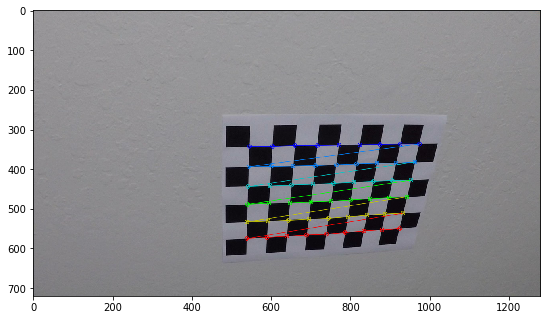

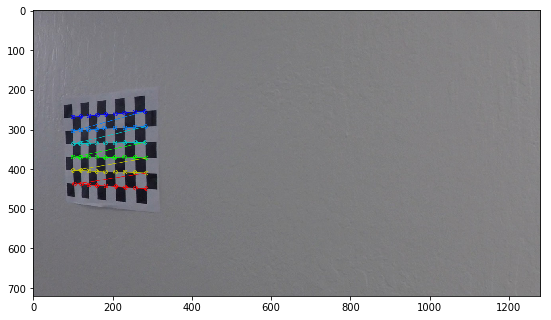

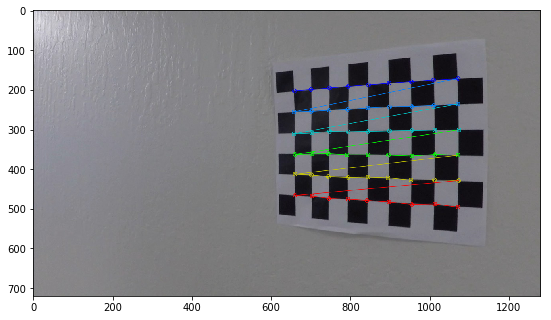

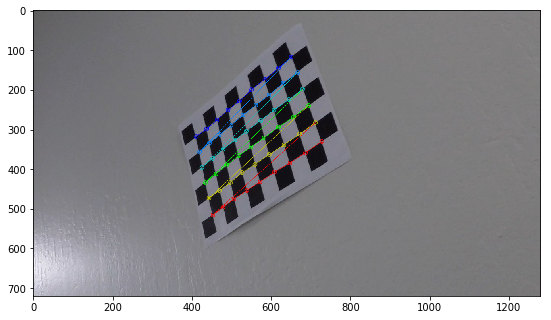

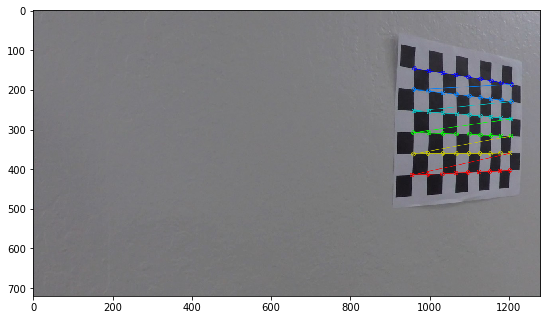

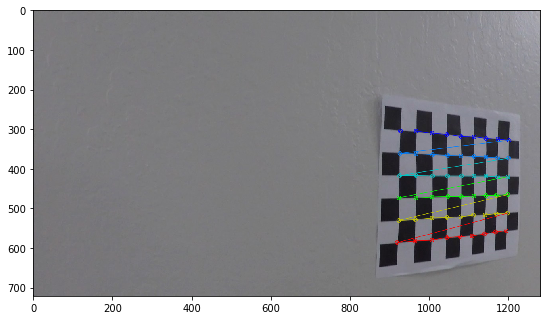

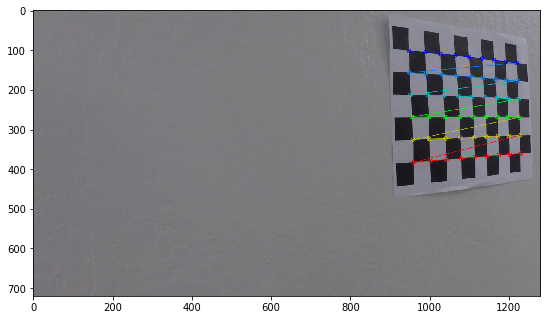

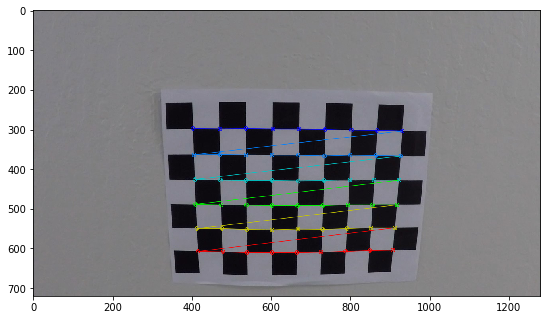

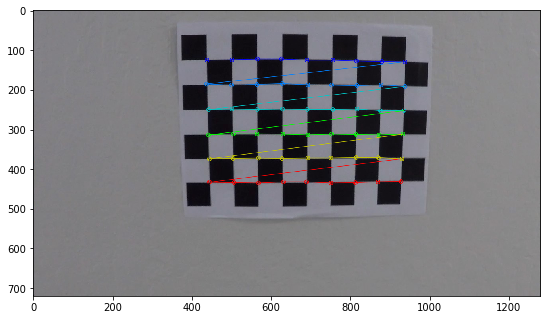

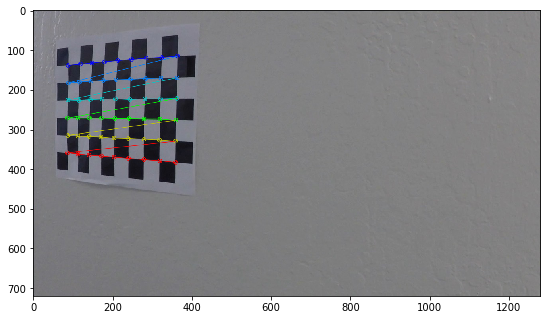

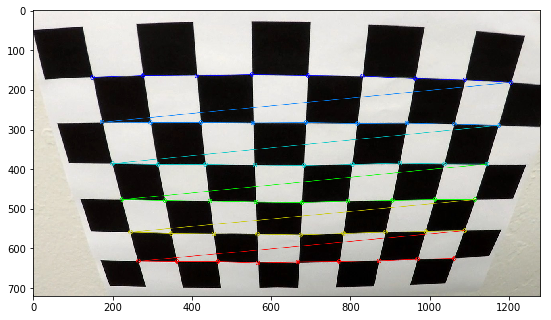

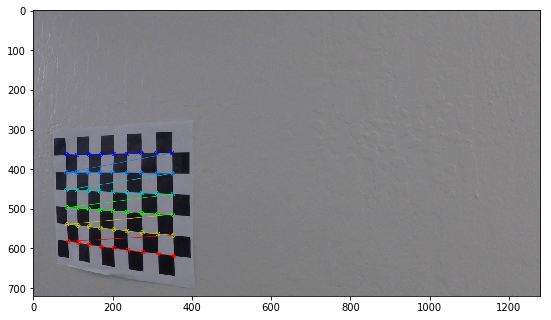

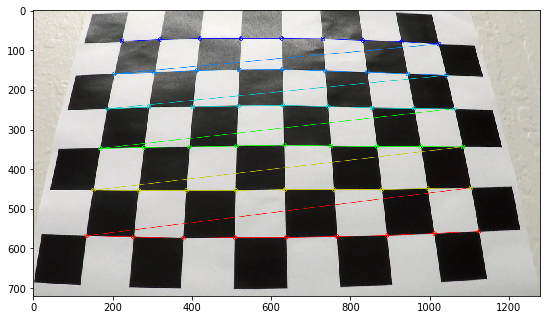

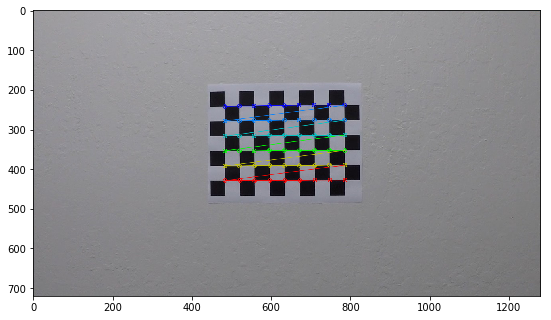

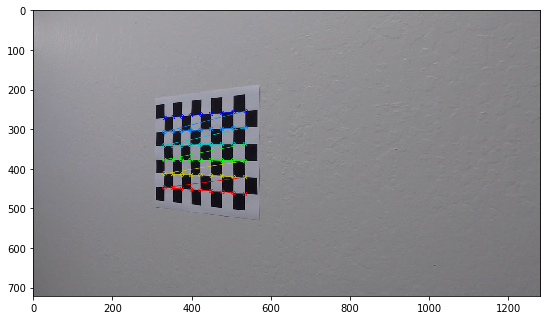

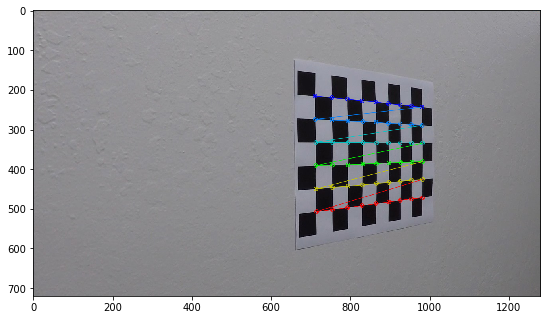

In [ ]:


#----------CALIBRATION----------------#
#object points for calibration
x_objpoints = 9
y_objpoints = 6

#object points and image points array. These arrays will be appended to as calibration images are being read.
objpoints = []
imgpoints = []

#prepare object points
objp = np.zeros((x_objpoints * y_objpoints, 3), np.float32)
objp[:,:2] = np.mgrid[0:x_objpoints, 0:y_objpoints].T.reshape(-1,2)

for file in cal_images:
    
    #1. Read an Image
    image = mpimg.imread(file)
    
    #2. Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #3. Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (x_objpoints,y_objpoints), None)
    
    #if all corners were found
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #4. drawy chessboard corners
        image = cv2.drawChessboardCorners(image,  (x_objpoints,y_objpoints), corners, ret)
        fig = plt.figure(figsize = (20,20))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(image)
        



In [ ]:
#We now have the object points and image points. These can be used to calculated the camera matrix and distortion coefficients.
#Undistorting Images
def undistort_values(image, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

image = mpimg.imread(cal_images[0])
# _mtx and _dist are the camera matrix and distortion values we will use to undistort all images
_mtx, _dist = undistort_values(image, objpoints, imgpoints)

def undistort_image(image, mtx = _mtx, dist = _dist):
    
    undist_image = cv2.undistort(image, mtx, dist, None, None)
    
    return undist_image



for file in cal_images:
    image = mpimg.imread(file)
    undistorted = undistort_image(image)
    
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    undistored_gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    
    ret_original, corners_original = cv2.findChessboardCorners(image_gray, (x_objpoints,y_objpoints), None)
    ret_undistort, corners_undistort = cv2.findChessboardCorners(undistored_gray, (x_objpoints,y_objpoints), None)
    
    image_corners = cv2.drawChessboardCorners(image,  (x_objpoints,y_objpoints), corners_original, ret_original)
    undistorted_corners = cv2.drawChessboardCorners(undistorted,  (x_objpoints,y_objpoints), corners_undistort, ret_undistort)
    
    fig = plt.figure(figsize = (20,20))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image_corners)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(undistorted_corners)


In [ ]:

for file in test_images:
    image = mpimg.imread(file)
    undistorted = undistort_image(image)
    
    
    fig = plt.figure(figsize = (20,20))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(image)
    ax1.set_title('Original', fontsize = 24)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted', fontsize = 24)

In [ ]:
#Select an image to transform. This image was chosen as the lanes are about vertically symmeterical
#along the image.
image = mpimg.imread(test_images[5])
undistorted = undistort_image(image)
image_size_x = image.shape[1]
image_size_y = image.shape[0]

#The source points were calcuated by adjusting the trapezium into the shape and position shown below
"""

Version 1 Perspective Transform
src_img = [
    (240., image_size_y), # left, bottom
    (630., 450.), # left, top
    (730., 450.), # right, top
    (1200., image_size_y), # right, bottom
    (240., image_size_y), # ignored
    ]


"""

#Version 2
src_img = [
    (240., image_size_y), # left, bottom
    (550., 500.), # left, top
    (800., 500.), # right, top
    (1200., image_size_y), # right, bottom
    (240., image_size_y), # ignored
    ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(src_img, codes)

fig = plt.figure(figsize = (25,25))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(undistorted)

patch = patches.PathPatch(path,  lw=2)
ax1.add_patch(patch)


#Based src_img, the src array is populated.
_src = np.float32(
   [[550., 500.], # left, top
    [240., image_size_y], # left, bottom
    [1200., image_size_y], # right, bottom
    [800., 500.]])# right, top
    

_dst = np.float32(
    [[(image_size_x / 4), 0],
    [(image_size_x / 4), image_size_y],
    [(image_size_x * 3 / 4), image_size_y],
    [(image_size_x * 3 / 4), 0]])

#Test of Perspecitve Transform

def transform_matrix( src = _src, dst = _dst):
    
    M = cv2.getPerspectiveTransform(_src, _dst)
    Minv = cv2.getPerspectiveTransform(_dst, _src)

    return M, Minv


M, Minv = transform_matrix( src = _src, dst = _dst)
def perspective_trans(image, M, image_size = (image_size_x, image_size_y)):
    
    warped_image = cv2.warpPerspective(image, M, image_size, flags = cv2.INTER_LINEAR)
    
    return warped_image

#Compute perspective transform
pers_image_test = perspective_trans(image, M)
fig = plt.figure(figsize = (25,25))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pers_image_test)


299 929
120775.591898 m 6006.25705377 m
329 909
227092.275149 m 177030.761479 m
315 919
118890.908995 m 2746740.1516 m
324 936
18415930.3098 m 21321530.9925 m
260 915
19217.118976 m 30430.8016705 m
331 950
31737.1870255 m 4149.35753068 m


"  \n    ax2 = fig.add_subplot(1,2,2) \n    ax2.imshow(color_warp)\n    ax2.plot(left_fitx, ploty, color='yellow', linewidth=3)\n    ax2.plot(right_fitx, ploty, color='yellow', linewidth=3)\n      \n\nfor file in test_images:\n    image = mpimg.imread(file)\n    plt.figure(figsize = (10,10))\n    plt.imshow(image)\n\n"

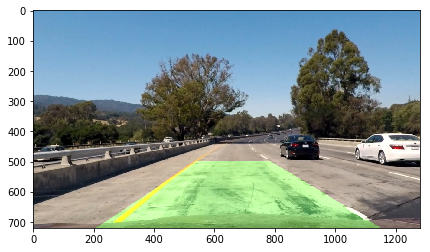

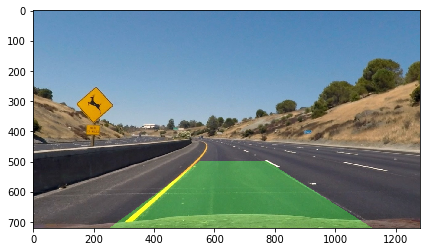

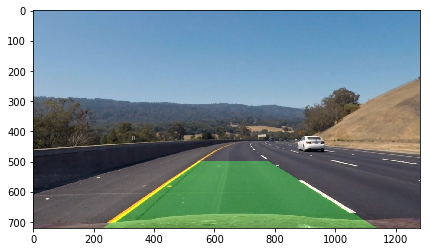

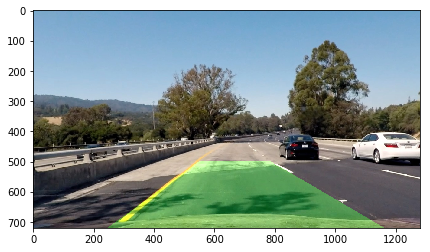

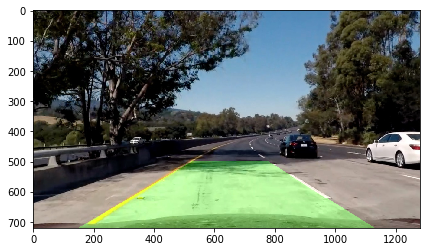

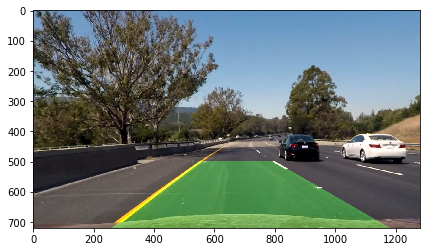

In [186]:
def hsv_split (img):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    return h_channel, l_channel, s_channel

def sobel(img, mag_thresh, sobel_kernel=11):

    # x derivative
    _sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # y derivative
    _sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    _absSobel = np.sqrt(_sobelx**2 + _sobely**2)
    _scaleSobel = np.uint8(255*_absSobel/np.max(_absSobel))

    
    _sobelBinary = np.zeros_like(_scaleSobel)
    _sobelBinary[(_scaleSobel >= mag_thresh[0]) & (_scaleSobel < mag_thresh[1])] = 1
    
    return _sobelBinary


def grad_dir(img, dir_thresh, sobel_kernel=11):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # x derivative
    _sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # y derivative
    _sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    _abs_x = np.absolute(_sobelx)
    _abs_y = np.absolute(_sobely)
    
    _dir = np.arctan2(_abs_y, _abs_x)
    
    binary_dir = np.zeros_like(gray)
    binary_dir[(_dir > dir_thresh[0]) & (_dir < dir_thresh[1])] = 1
    
    return binary_dir
    
    
def grad_color(img, s_thresh):
    
   
    s_binary = np.zeros_like(img)
    
    s_binary[(img > s_thresh[0]) & (img <= s_thresh[1])] = 1
    
    return s_binary

def image_combiner(img1, img2):
    
    combined = np.dstack(( np.zeros_like(img1), img1, img2))
    
    return combined


def hist(binary_warped):
    
    #histogram = np.sum(binary_warped[int(binary_warped.shape[0]):,:], axis=0)
    histogram = np.sum(binary_warped[:,:], axis=0)
    return histogram

def smooth_hist(binary_warped):
    
    #histogram = np.sum(binary_warped[int(binary_warped.shape[0]):,:], axis=0)
    histogram = np.sum(binary_warped[:,:], axis=0)
    smooth_histogram = gaussian_filter1d(histogram, 10)
    return smooth_histogram

def find_peaks(smooth_histogram):
    
    peakind = signal.find_peaks_cwt(smooth_histogram, np.arange(1, smooth_histogram.shape[0]) )
    return peakind


def lane_coordinates (image, image_strips, histogram, window_width, min_pixels):
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    image_height = image.shape[0]
    
    #------------------------------------
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    print(left_peak, right_peak)
    # Set height of windows
    strip_height = np.int(image_height/image_strips)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_index = []
    right_lane_index = []
        
    for strip in range(image_strips):
        
        #One window will slide in each stirp
        strip_bottom = image_height - (strip + 1)*strip_height
        strip_top = image_height - strip*strip_height
        
        #There will be two lanes in each strip: the left lane and right lane
        left_lane_window_low = left_peak - window_width
        left_lane_window_high = left_peak + window_width
        
        right_lane_window_low = right_peak - window_width
        right_lane_window_high = right_peak + window_width
        
        # Identify the nonzero pixels in x and y within the window
        good_left_index = ((nonzeroy >= strip_bottom) & (nonzeroy < strip_top) & (nonzerox >= left_lane_window_low) & (nonzerox < left_lane_window_high)).nonzero()[0]
        good_right_index = ((nonzeroy >= strip_bottom) & (nonzeroy < strip_top) & (nonzerox >= right_lane_window_low) & (nonzerox < right_lane_window_high)).nonzero()[0]
        
        left_lane_index.append(good_left_index)
        right_lane_index.append(good_right_index)
        
        if (len(good_left_index) > min_pixels):
            left_peak = np.int(np.mean(nonzerox[good_left_index]))
        
        if (len(good_right_index) > min_pixels):
            right_peak = np.int(np.mean(nonzerox[good_right_index]))
    

    left_lane_index = np.concatenate(left_lane_index)
    right_lane_index = np.concatenate(right_lane_index)
    
    #out_img[nonzeroy[left_lane_index], nonzerox[left_lane_index]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_index], nonzerox[right_lane_index]] = [0, 0, 255]
    
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_index]
    lefty = nonzeroy[left_lane_index] 
    rightx = nonzerox[right_lane_index]
    righty = nonzeroy[right_lane_index]
    
    return leftx, lefty, rightx, righty

def lane_separation(leftx, rightx):
    
    separation = abs(leftx.mean() - rightx.mean())
    
    #print(separation)
    return separation

def lane_adjustment(leftx, lefty, rightx, righty, minimum_percent = 15):

    offset = lane_separation(leftx, rightx)
    minimum_percent_dec = float(minimum_percent/100)
    if (len(leftx) < (minimum_percent_dec * len(rightx))):
        adjusted_leftx = rightx - offset
        adjusted_lefty = righty
        adjusted_rightx = rightx
        adjusted_righty = righty
    
    elif (len(rightx) < (minimum_percent_dec * len(leftx))):
        adjusted_leftx = leftx 
        adjusted_lefty = lefty
        adjusted_rightx = leftx + offset
        adjusted_righty = lefty
        
    else:
        adjusted_leftx = leftx 
        adjusted_lefty = lefty
        adjusted_rightx = rightx
        adjusted_righty = righty
    return adjusted_leftx, adjusted_lefty, adjusted_rightx, adjusted_righty

def lane_polynomial(leftx, lefty, rightx, righty):

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #print('grad', np.gradient(left_fit))
    #print('grad', np.gradient(right_fit))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    
    return right_fitx, left_fitx, ploty



def radius_of_curve(leftx, lefty, rightx, righty):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_left_eval = np.max(lefty)
    y_right_eval = np.max(righty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_left_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_right_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #print (left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_fit_cr, right_fit_cr


    
def unwarp_lines(warped_image, undist, right_fitx, left_fitx, ploty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


    

def pipeline(image, s_thresh=(160, 220), mag_thresh=(40,160), dir_thresh = (0.9, 1.3)):
    
    undistorted = undistort_image(image)
    p_trans = perspective_trans(undistorted, M)
    v_channel, l_channel, s_channel = hsv_split(p_trans)
    
    s_sobel = sobel(s_channel, mag_thresh)
    s_color = grad_color(s_channel,  s_thresh)
    result = image_combiner(s_sobel, s_color)
    s_dir = grad_dir(undistorted, dir_thresh)
    combined_color_sobel = np.zeros_like(s_dir)
    combined_sobel_dir = np.zeros_like(s_dir)
    
    combined_color_sobel[(s_color == 1) | (s_sobel == 1)] = 1
    combined_sobel_dir[(s_color == 1) & (s_dir == 1) ] = 1
    #p_trans = perspective_trans(combined_color_sobel)
    #histogram_image = hist(combined_color_sobel)
    
    binary_warped = combined_color_sobel

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #histogram = hist(binary_warped)
    smooth_histogram = smooth_hist(binary_warped)
    #peaks = find_peaks(smooth_histogram)

    leftx, lefty, rightx, righty = lane_coordinates(binary_warped, 9, smooth_histogram, 100, 50)
    
    
    adjusted_leftx, adjusted_lefty, adjusted_rightx, adjusted_righty = lane_adjustment(leftx, lefty, rightx, righty)
    right_fitx, left_fitx, ploty = lane_polynomial(adjusted_leftx, adjusted_lefty, adjusted_rightx, adjusted_righty)
    left_fit_cr, right_fit_cr = radius_of_curve(adjusted_leftx, adjusted_lefty, adjusted_rightx, adjusted_righty)
    
    final_result  = unwarp_lines(binary_warped, undistorted, right_fitx, left_fitx, ploty)
    
    return final_result



for file in test_images:
    
    image = mpimg.imread(file)
    undistorted = undistort_image(image)
    
    
    binary_warped = pipeline(image)
    
    
    
    
    
    fig = plt.figure(figsize = (20,4))
    ax1 = fig.add_subplot(1,2,1)
    #ax1.plot(smooth_histogram)
    ax1.imshow(binary_warped)

"""  
    ax2 = fig.add_subplot(1,2,2) 
    ax2.imshow(color_warp)
    ax2.plot(left_fitx, ploty, color='yellow', linewidth=3)
    ax2.plot(right_fitx, ploty, color='yellow', linewidth=3)
      

for file in test_images:
    image = mpimg.imread(file)
    plt.figure(figsize = (10,10))
    plt.imshow(image)

"""



In [87]:
#Clear the buffer for new road
#buffers.clear_buffers()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video1.mp4'
clip1 = VideoFileClip('project_video.mp4')
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video1.mp4
[MoviePy] Writing video project_video1.mp4


100%|█████████▉| 1260/1261 [00:21<00:00, 57.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video1.mp4 

Wall time: 22.6 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[array([19618, 19619, 19620, ..., 24009, 24010, 24011], dtype=int64)]
309
<class 'list'>
[array([19618, 19619, 19620, ..., 24009, 24010, 24011], dtype=int64), array([14480, 14481, 14482, ..., 19521, 19522, 19523], dtype=int64)]
321
<class 'list'>
[array([19618, 19619, 19620, ..., 24009, 24010, 24011], dtype=int64), array([14480, 14481, 14482, ..., 19521, 19522, 19523], dtype=int64), array([12534, 12535, 12536, ..., 14477, 14478, 14479], dtype=int64)]
323
<class 'list'>
[array([19618, 19619, 19620, ..., 24009, 24010, 24011], dtype=int64), array([14480, 14481, 14482, ..., 19521, 19522, 19523], dtype=int64), array([12534, 12535, 12536, ..., 14477, 14478, 14479], dtype=int64), array([10964, 10965, 10966, ..., 12531, 12532, 12533], dtype=int64)]
318
<class 'list'>
[array([19618, 19619, 19620, ..., 24009, 24010, 24011], dtype=int64), array([14480, 14481, 14482, ..., 19521, 19522, 19523], dtype=int64), array([12534, 12535, 12536, ..., 14477, 14478, 14479], dtype=int64), array([10964, 10965, 1

'\n# Assume you now have a new warped binary image \n# from the next frame of video (also called "binary_warped")\n# It\'s now much easier to find line pixels!\nnonzero = binary_warped.nonzero()\nnonzeroy = np.array(nonzero[0])\nnonzerox = np.array(nonzero[1])\nmargin = 100\nleft_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) \nright_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  \n\n# Again, extract left and right line pixel positions\nleftx = nonzerox[left_lane_inds]\nlefty = nonzeroy[left_lane_inds]\nrightx = nonzerox[right_lane_inds]\nrighty = nonzeroy[right_lane_inds]\n# Fit a second order polynomial to each\nleft_fit = np.polyfit(lefty, leftx, 2)\nright_fit = np.polyfit(righty, rightx, 2)\n# 

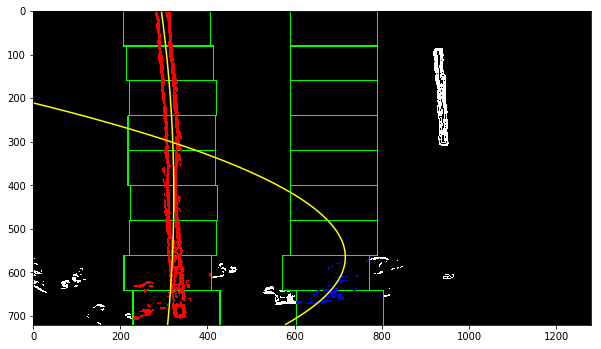

In [855]:
image = mpimg.imread(test_images[3])

binary_warped = pipeline(image)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

#------------------------------------
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


plt.figure(figsize = (10,10))
ax1.imshow(out_img)
ax2.plot(histogram)

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


def lane_polynomials (image, image_stips, left_peak, right_peak, window_width, min_pixels):

    image_height = image.shape[0]
    
    # Set height of windows
    strip_height = np.int(image_height/image_strips)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_index = []
    right_lane_index = []
    
    for strip in range(image_strips):
        
        #One window will slide in each stirp
        strip_bottom = image_height - (window + 1)*strip_height
        strip_top = image_height - window*strip_height
        
        #There will be two lanes in each strip: the left lane and right lane
        left_lane_window_low = left_peak - window_width
        left_lane_window_high = left_peak + window_width
        
        right_lane_window_low = right_peak - window_width
        right_lane_window_high = right_peak + window_width
        
        # Identify the nonzero pixels in x and y within the window
        good_left_index = ((nonzeroy >= strip_bottom) & (nonzeroy < strip_top) & (nonzerox >= left_lane_window_low) & (nonzerox < left_lane_window_high)).nonzero()[0]
        good_right_index = ((nonzeroy >= strip_bottom) & (nonzeroy < strip_top) & (nonzerox >= right_lane_window_low) & (nonzerox < right_lane_window_high)).nonzero()[0]
        
        left_lane_index.append(good_left_index)
        right_lane_index.append(good_right_index)
        
        if (len(good_left_index) > min_pixels):
            left_peak = np.int(np.mean(nonzerox[good_left_index]))
        
        if (len(good_right_index) > min_pixels):
            right_peak = np.int(np.mean(nonzerox[good_right_index]))
    

    left_lane_index = np.concatenate(left_lane_index)
    right_lane_index = np.concatenate(right_lane_index)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_index]
    lefty = nonzeroy[left_lane_index] 
    rightx = nonzerox[right_lane_index]
    righty = nonzeroy[right_lane_index] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit, right_fit
    
        
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    print(left_lane_inds)
    print(leftx_current)
    print(type(left_lane_inds))
    
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
print(type(left_lane_inds))
print(left_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
print(lefty)
print(leftx)
print(rightx)
print(righty)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
"""
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
"""


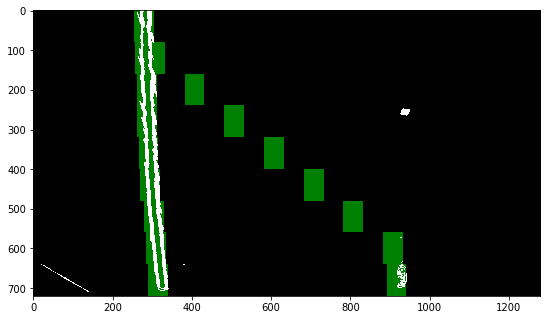

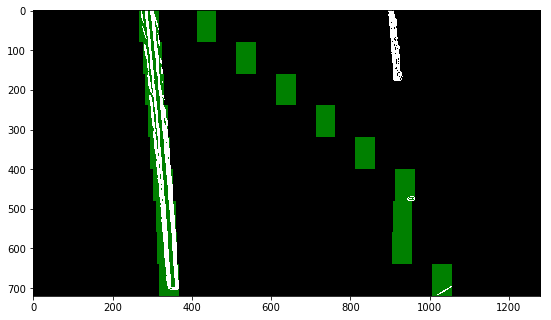

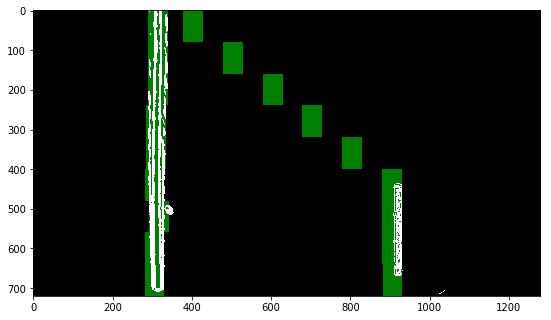

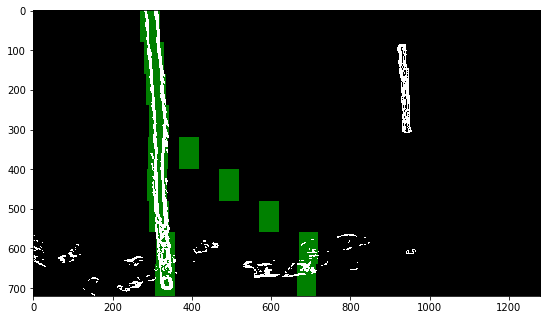

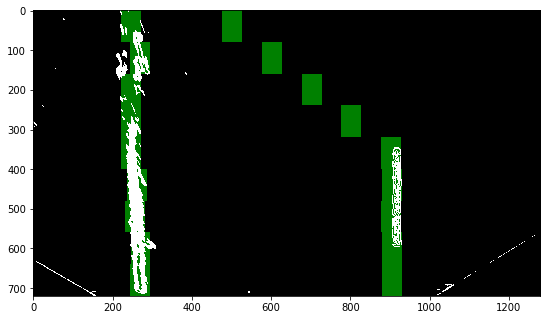

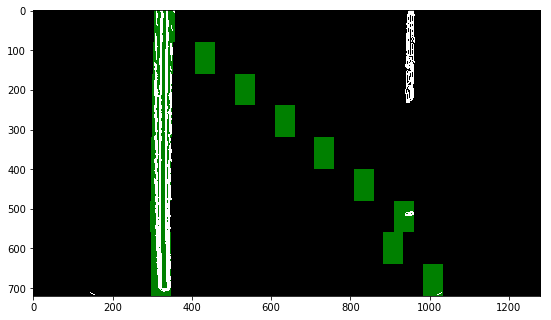

In [827]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

for file in test_images:
    # Read in a thresholded image
    image = mpimg.imread(file)
    out_img = pipeline(image)
    outimg2 = np.dstack((out_img, out_img, out_img))*255

    warped = cv2.cvtColor(outimg2, cv2.COLOR_RGB2GRAY)
    histogram = smooth_hist(warped)
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    fig = plt.figure(figsize = (20,20))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(output)
    